In [1]:
%load_ext autoreload
%autoreload 2
%cd '../HOTS'
%matplotlib inline

/home/antoine/homhots/HOTS/HOTS


In [2]:
import tonic
from mix_TimeSurface import TimeSurface
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import os
import pickle
import datetime
from mix_Network import *

def printfig(fig, name):
    dpi_exp = None
    bbox = 'tight'
    path = '../../paper/5f22d412742c360001c92b46/fig/'
    fig.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox)

# Stream.png

In [3]:
learningset = tonic.datasets.POKERDVS(save_to='../Data/', train = False,
                                transform=None)
loader = tonic.datasets.DataLoader(learningset, shuffle=True)

Using downloaded and verified file: ../Data/pips_test.tar.gz
Extracting ../Data/pips_test.tar.gz to ../Data/


In [4]:
print(learningset)

Dataset POKERDVS
    Number of datapoints: 20
    Root location: ../Data/


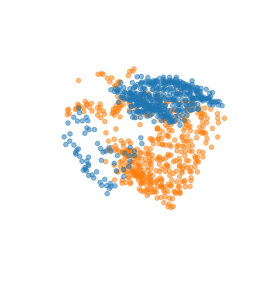

In [5]:
        target_event = 1000
        X_on = []
        Y_on = []
        T_on = []
        X_off = []
        Y_off = []
        T_off = []
        iev = 100
        events, target = next(iter(loader))
        while iev<target_event:
            x,y,t,p = events[0][iev][learningset.ordering.find("x")].item(), \
                    events[0][iev][learningset.ordering.find("y")].item(), \
                    events[0][iev][learningset.ordering.find("t")].item(), \
                    events[0][iev][learningset.ordering.find("p")].item()
            if p:
                X_on.append(x)
                Y_on.append(abs(learningset.sensor_size[1]-y))
                T_on.append(t)
            else:
                X_off.append(x)
                Y_off.append(abs(learningset.sensor_size[1]-y))
                T_off.append(t)
            iev+=1
        fig = plt.figure(figsize=(10,5))
        sub1 = fig.add_subplot(1,2,1, projection="3d")
        sub1.scatter(T_on, X_on, Y_on, cmap= plt.cm.plasma, alpha=0.5)
        sub1.scatter(T_off, X_off, Y_off, cmap= plt.cm.plasma, alpha=0.5)
        #sub1.arrow([0,max(T_off)], [0,0], [0,0])
        sub1.view_init(10,-40)
        sub1.grid(b = None)
        sub1.set_xlabel('time')
        sub1.axis('off')
        plt.show()

In [6]:
printfig(fig, 'stream.png')

# Flux.png

In [7]:
learningset = tonic.datasets.NMNIST(save_to='../Data/', train = False,
                                transform=None)
loader = tonic.datasets.DataLoader(learningset, shuffle=True)

Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


In [8]:
target_event = 2000
TS = TimeSurface(R=2,tau=5*10e3,camsize=[34,34])
events, target = next(iter(loader))
flxT = TS.spatpmat.copy()
iev = 0
while iev<target_event:
    x,y,t,p = events[0][iev][learningset.ordering.find("x")].item(), \
                events[0][iev][learningset.ordering.find("y")].item(), \
                events[0][iev][learningset.ordering.find("t")].item(), \
                events[0][iev][learningset.ordering.find("p")].item(),
    flxT[p,x,y] = t
    ts, activ = TS.addevent(x,y,t,p)
    iev+=1

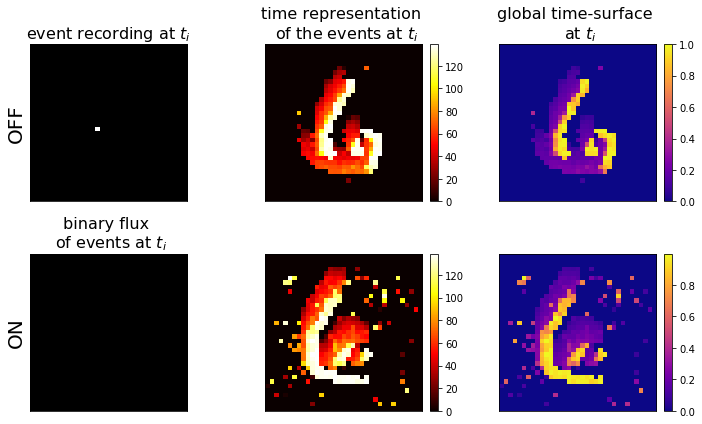

In [9]:
polaritiz = ['OFF','ON']
gamma = 1
fig, axs = plt.subplots(2,3,figsize=(10,6))

Ti = np.zeros(learningset.sensor_size)
singev = axs[abs(p-1),0].imshow(Ti.T, cmap='gray')
axs[abs(p-1),0].set_title('binary flux \n of events at $t_i$', fontsize=16)
axs[abs(p-1),0].set_ylabel(f'{polaritiz[abs(p-1)]}', fontsize=20)
axs[abs(p-1),0].set_xticks(())
axs[abs(p-1),0].set_yticks(())

Ti[x,y] = 1
singev = axs[p,0].imshow(Ti.T, cmap='gray')
#axs[p,0].set_title('binary flux of events at $t_i$', fontsize=16) #for NN
if p==0:
    axs[p,0].set_title('event recording at $t_i$', fontsize=16)
axs[p,0].set_ylabel(f'{polaritiz[p]}', fontsize=20)
axs[p,0].set_xticks(())
axs[p,0].set_yticks(())

for p in [0,1]:
    T = axs[p,1].imshow(flxT[p].T*1e-3, cmap='hot')
    #axs[p,1].set_title('T flux at $t_i$ (in $ms$)', fontsize=16) #for NN
    if p==0:
        axs[p,1].set_title('time representation \n of the events at $t_i$', fontsize=16)
    axs[p,1].set_xticks(())
    axs[p,1].set_yticks(())
    plt.colorbar(T, ax=axs[p,1], fraction=0.046, pad=0.04);
    
    S = axs[p,2].imshow(TS.spatpmat[p].T, cmap=plt.cm.plasma)
    #axs[p,2].set_title('S flux at $t_i$', fontsize=16) #for NN
    if p==0:
        axs[p,2].set_title('global time-surface \n at $t_i$', fontsize=16)
    axs[p,2].set_xticks(())
    axs[p,2].set_yticks(())
    cbar = plt.colorbar(S, ax=axs[p,2], fraction=0.046, pad=0.04);
    #cbar.set_label(fonsize=16)
    
fig.tight_layout()

In [10]:
printfig(fig, 'flux.png')

# Layers.png

In [11]:
dataset = 'nmnist'
records_path = '../Records'
timestr = datetime.datetime.now().date().isoformat()
timestr = '2021-01-06'

%mkdir -p ../Records
%mkdir -p ../Records/EXP_03_NMNIST

homeo = True
sigma = None
pooling = False
homeinv = False
jitter = False
tau = 5
nb_train = 5000
nb_test = 100
krnlinit = 'rdn'
nblay = 3
nbclust = 4
filt = 2

hotshom = network(krnlinit=krnlinit, filt=filt, tau=tau, nblay=nblay, nbclust=nbclust, homeo=homeo, sigma=sigma, homeinv=homeinv, jitter=jitter)
hotshom = hotshom.learningall(dataset=dataset)

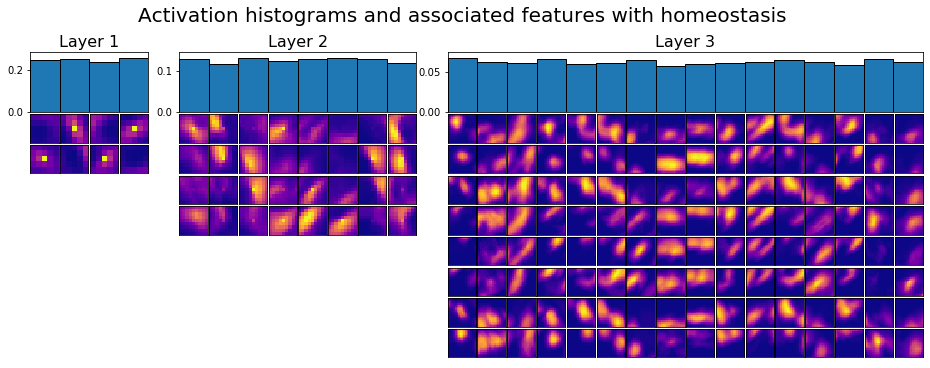

In [12]:
fig = hotshom.plotlayer()

In [13]:
printfig(fig, 'layerwiz.png')

In [14]:
homeo = False
krnlinit = 'first'
hotshom = network(krnlinit=krnlinit, filt=filt, tau=tau, nblay=nblay, nbclust=nbclust, homeo=homeo, sigma=sigma, homeinv=homeinv, jitter=jitter)
hotshom = hotshom.learning1by1(dataset=dataset)

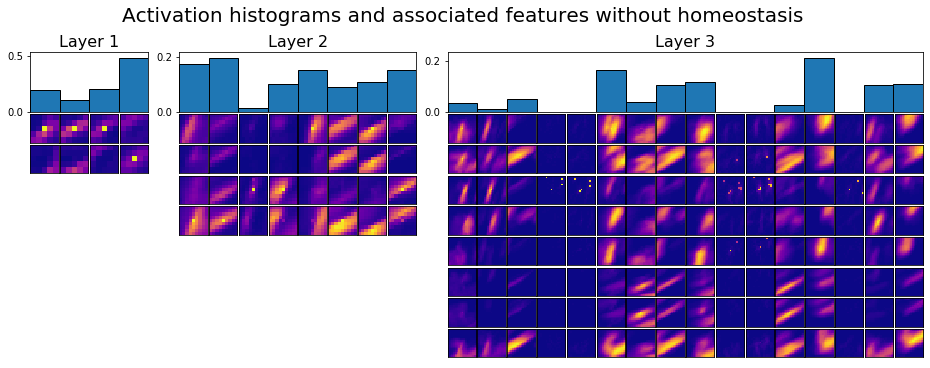

In [15]:
fig = hotshom.plotlayer()

In [16]:
printfig(fig, 'layerwizout.png')

# Jitter.png

In [17]:
def runjit(hotshom, jit_s, jit_t):
    score_S = []
    score_T = []
    for i in jit_s:
        i = round(i,1)
        jitonic = [None,i]
        testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic)
        JS_score = histoscore(trainhistomap,testhistomap, verbose = False)
        print(f'loading... - spatial jitter = {i} - score = {JS_score}',end='\r')
        score_S.append(JS_score)

    for j in jit_t:
        j = round(j,1)
        jitonic = [j,None]
        testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic)
        JS_score = histoscore(trainhistomap,testhistomap, verbose = False)
        print(f'loading... - temporal jitter = {j} - score = {JS_score}',end='\r')
        score_T.append(JS_score)
    return score_S, score_T

In [18]:
dataset = 'nmnist'
records_path = '../Records'
timestr = '2021-02-13'
homeo = False
homeotest = False
sigma = None
pooling = False
homeinv = False
jitonic = [None,None] #[temporal, spatial]
jitter = False
tau = 5
nb_train = 5000
nb_test = 100
krnlinit = 'rdn'
nblay = 3
nbclust = 4
filt = 2
jit_s = np.arange(0,5,0.2)
jit_t = np.arange(0,300,10)
jit_t, jit_s = jit_t**2, jit_s**2

In [19]:
hotshom = network(krnlinit=krnlinit, filt=filt, tau=tau, nblay=nblay, nbclust=nbclust, homeo=homeo, sigma=sigma, homeinv=homeinv, jitter=jitter)
hotshom = hotshom.learning1by1(dataset=dataset)
trainhistomap = hotshom.running(homeotest = homeotest, nb_digit=nb_train)

../Records/nmnist/train/2021-02-13_lagorce_first_None_False_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_5000_[None, None]_histo.pkl


In [58]:
score_S, score_T = runjit(hotshom, jit_s, jit_t)
f_name = f'{records_path}/{dataset}/{timestr}_results_jitter_histo_online.pkl'
with open(f_name, 'wb') as file:
    pickle.dump([score_T, jit_t, score_S, jit_s], file, pickle.HIGHEST_PROTOCOL)

../Records/nmnist/test/2021-02-13_lagorce_first_None_False_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_100_[None, 0.0]_histo.pkl


KeyboardInterrupt: 

In [21]:
import pickle
f_name = f'{records_path}/{dataset}/{timestr}_results_jitter_histo_homeo_homeotest.pkl'
with open(f_name, 'rb') as file:
    score_THH, jit_t, score_SHH, jit_s = pickle.load(file)

In [22]:
import pickle
f_name = f'{records_path}/{dataset}/{timestr}_results_jitter_histo_homeo.pkl'
with open(f_name, 'rb') as file:
    score_TH, tim_jit, score_SH, spa_jit = pickle.load(file)

In [23]:
import pickle
f_name = f'{records_path}/{dataset}/{timestr}_results_jitter_histo_hots.pkl'
with open(f_name, 'rb') as file:
    score_T, jit_t, score_S, jit_s = pickle.load(file)

In [24]:
jit_t, jit_s = np.sqrt(jit_t), np.sqrt(jit_s)

In [25]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type("torch.DoubleTensor")
criterion = torch.nn.BCELoss(reduction="mean")

class LRModel_tim_HH(torch.nn.Module):
    def __init__(self, bias=True, logit0=-2, jitter0=120, log_wt=torch.log(10*torch.ones(1)), n_classes=10):
        super(LRModel_tim_HH, self).__init__()
        #self.linear = torch.nn.Linear(1, 1, bias=bias)
        self.jitter0 = torch.nn.Parameter(jitter0 * torch.ones(1))
        self.logit0 = torch.nn.Parameter(logit0 * torch.ones(1))
        self.log_wt = torch.nn.Parameter(log_wt * torch.ones(1))
        self.n_classes = n_classes

    def forward(self, jitter):
        p0 = torch.sigmoid(self.logit0)
        p = torch.sigmoid((self.jitter0-jitter)/torch.exp(self.log_wt))
        out = 1/self.n_classes + (1 - p0 - 1/self.n_classes) * p
        #out = 1-p0 / 2 + (1 - p0) * torch.sigmoid((jitter-self.jitter0 )/torch.exp(self.log_wt))
        return out

learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
batch_size = 256
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

def fit_data(model,
    theta,
    y,
    learning_rate=learning_rate,
    batch_size=batch_size,  # gamma=gamma,
    num_epochs=num_epochs,
    betas=betas,
    verbose=False, **kwargs
):

    Theta, labels = torch.Tensor(theta[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    logistic_model = model()
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for Theta_, labels_ in loader:
            Theta_, labels_ = Theta_.to(device), labels_.to(device)
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.sum(losses)/len(theta):.5f}")

    logistic_model.eval()
    Theta, labels = torch.Tensor(theta[:, None]).to(device), torch.Tensor(y[:, None]).to(device)
    outputs = logistic_model(Theta)
    loss = criterion(outputs, labels).item() / len(theta)
    return logistic_model, loss

In [26]:
class LRModel_tim_H(torch.nn.Module):
    def __init__(self, bias=True, logit0=2, jitter0=120, log_wt=torch.log(1*torch.ones(1)), n_classes=10):
        super(LRModel_tim_H, self).__init__()
        #self.linear = torch.nn.Linear(1, 1, bias=bias)
        self.jitter0 = torch.nn.Parameter(jitter0 * torch.ones(1))
        self.logit0 = torch.nn.Parameter(logit0 * torch.ones(1))
        self.log_wt = torch.nn.Parameter(log_wt * torch.ones(1))
        self.n_classes = n_classes

    def forward(self, jitter):
        p0 = torch.sigmoid(self.logit0)
        p = torch.sigmoid((self.jitter0-jitter)/torch.exp(self.log_wt))
        out = 1/self.n_classes + (1 - p0 - 1/self.n_classes) * p
        #out = 1-p0 / 2 + (1 - p0) * torch.sigmoid((jitter-self.jitter0 )/torch.exp(self.log_wt))
        return out
    
class LRModel_tim(torch.nn.Module):
    def __init__(self, bias=True, logit0=0, jitter0=120, log_wt=torch.log(10*torch.ones(1)), n_classes=10):
        super(LRModel_tim, self).__init__()
        #self.linear = torch.nn.Linear(1, 1, bias=bias)
        self.jitter0 = torch.nn.Parameter(jitter0 * torch.ones(1))
        self.logit0 = torch.nn.Parameter(logit0 * torch.ones(1))
        self.log_wt = torch.nn.Parameter(log_wt * torch.ones(1))
        self.n_classes = n_classes

    def forward(self, jitter):
        p0 = torch.sigmoid(self.logit0)
        p = torch.sigmoid((self.jitter0-jitter)/torch.exp(self.log_wt))
        out = 1/self.n_classes + (1 - p0 - 1/self.n_classes) * p
        #out = 1-p0 / 2 + (1 - p0) * torch.sigmoid((jitter-self.jitter0 )/torch.exp(self.log_wt))
        return out

In [48]:
logistic_model_THH, loss_THH = fit_data(LRModel_tim_HH, jit_t, np.array(score_THH), verbose=False)
logistic_model_TH, loss_TH = fit_data(LRModel_tim_H, jit_t, np.array(score_TH), verbose=False)
logistic_model_T, loss_T = fit_data(LRModel_tim, jit_t, np.array(score_T), verbose=False)

In [49]:
class LRModel_spa_HH(torch.nn.Module):
    def __init__(self, bias=True, logit0=-2, jitter0=1.5, log_wt=torch.log(2*torch.ones(1)), n_classes=10):
        super(LRModel_spa_HH, self).__init__()
        #self.linear = torch.nn.Linear(1, 1, bias=bias)
        self.jitter0 = torch.nn.Parameter(jitter0 * torch.ones(1))
        self.logit0 = torch.nn.Parameter(logit0 * torch.ones(1))
        self.log_wt = torch.nn.Parameter(log_wt * torch.ones(1))
        self.n_classes = n_classes

    def forward(self, jitter):
        p0 = torch.sigmoid(self.logit0)
        p = torch.sigmoid((self.jitter0-jitter)/torch.exp(self.log_wt))
        out = 1/self.n_classes + (1 - p0 - 1/self.n_classes) * p
        #out = 1-p0 / 2 + (1 - p0) * torch.sigmoid((jitter-self.jitter0 )/torch.exp(self.log_wt))
        return out

class LRModel_spa_H(torch.nn.Module):
    def __init__(self, bias=True, logit0=0, jitter0=0, log_wt=torch.log(2*torch.ones(1)), n_classes=10):
        super(LRModel_spa_H, self).__init__()
        #self.linear = torch.nn.Linear(1, 1, bias=bias)
        self.jitter0 = torch.nn.Parameter(jitter0 * torch.ones(1))
        self.logit0 = torch.nn.Parameter(logit0 * torch.ones(1))
        self.log_wt = torch.nn.Parameter(log_wt * torch.ones(1))
        self.n_classes = n_classes

    def forward(self, jitter):
        p0 = torch.sigmoid(self.logit0)
        p = torch.sigmoid((self.jitter0-jitter)/torch.exp(self.log_wt))
        out = 1/self.n_classes + (1 - p0 - 1/self.n_classes) * p
        #out = 1-p0 / 2 + (1 - p0) * torch.sigmoid((jitter-self.jitter0 )/torch.exp(self.log_wt))
        return out
    
class LRModel_spa(torch.nn.Module):
    def __init__(self, bias=True, logit0=0, jitter0=0, log_wt=torch.log(2*torch.ones(1)), n_classes=10):
        super(LRModel_spa, self).__init__()
        #self.linear = torch.nn.Linear(1, 1, bias=bias)
        self.jitter0 = torch.nn.Parameter(jitter0 * torch.ones(1))
        self.logit0 = torch.nn.Parameter(logit0 * torch.ones(1))
        self.log_wt = torch.nn.Parameter(log_wt * torch.ones(1))
        self.n_classes = n_classes

    def forward(self, jitter):
        p0 = torch.sigmoid(self.logit0)
        p = torch.sigmoid((self.jitter0-jitter)/torch.exp(self.log_wt))
        out = 1/self.n_classes + (1 - p0 - 1/self.n_classes) * p
        #out = 1-p0 / 2 + (1 - p0) * torch.sigmoid((jitter-self.jitter0 )/torch.exp(self.log_wt))
        return out

In [50]:
logistic_model_SHH, loss_SHH = fit_data(LRModel_spa_HH, jit_s, np.array(score_SHH), verbose=False)
logistic_model_SH, loss_SH = fit_data(LRModel_spa_H, jit_s, np.array(score_SH), verbose=False)
logistic_model_S, loss_S = fit_data(LRModel_spa, jit_s, np.array(score_S), verbose=False)

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = np.array(jit_t)
x_values = torch.Tensor(x[:, None]).to(device)
fit_THH = torch.squeeze(logistic_model_THH(x_values)).cpu()
fit_TH = torch.squeeze(logistic_model_TH(x_values)).cpu()
fit_T = torch.squeeze(logistic_model_T(x_values)).cpu()
jt_values = x_values.cpu()
x = np.array(jit_s)
x_values = torch.Tensor(x[:, None]).to(device)
fit_SHH = torch.squeeze(logistic_model_SHH(x_values)).cpu()
fit_SH = torch.squeeze(logistic_model_SH(x_values)).cpu()
fit_S = torch.squeeze(logistic_model_S(x_values)).cpu()
js_values = x_values.cpu()

In [52]:
print(score_TH)

[0.84, 0.81, 0.87, 0.74, 0.85, 0.82, 0.88, 0.78, 0.79, 0.74, 0.71, 0.69, 0.72, 0.68, 0.55, 0.52, 0.45, 0.28, 0.28, 0.21, 0.25, 0.29, 0.22, 0.15, 0.11, 0.14, 0.14, 0.13, 0.19, 0.13]


In [53]:
def signumber(x,nb):
    c = np.log10(x)
    C = int(np.floor(c))
    b = x/10**C
    B = np.round(b,nb)
    if not C:
        num = f'{B}'
    elif C==-1:
        num = f'{np.round(B/10,nb+1)}'
    elif C==1:
        num = f'{np.round(B*10,nb-1)}'
    else:
        num = f'{B}e{C}'
    return num

In [54]:
nb_significatif = 1
param_SHH = f"param: w_t = {signumber(torch.exp(logistic_model_SHH.log_wt).item(),nb_significatif)}"+\
f" - jitter0 = {signumber(torch.exp(logistic_model_SHH.jitter0).item(),nb_significatif)}"+\
f" - logit0 = {signumber(torch.exp(logistic_model_SHH.logit0).item(),nb_significatif)}"
param_SH = f"param: w_t = {signumber(torch.exp(logistic_model_SH.log_wt).item(),nb_significatif)}"+\
f" - jitter0 = {signumber(torch.exp(logistic_model_SH.jitter0).item(),nb_significatif)}"+\
f" - logit0 = {signumber(torch.exp(logistic_model_SH.logit0).item(),nb_significatif)}"
param_S = f"param: w_t = {signumber(torch.exp(logistic_model_S.log_wt).item(),nb_significatif)}"+\
f" - jitter0 = {signumber(torch.exp(logistic_model_S.jitter0).item(),nb_significatif)}"+\
f" - logit0 = {signumber(torch.exp(logistic_model_S.logit0).item(),nb_significatif)}"
param_THH = f"param: w_t = {signumber(torch.exp(logistic_model_THH.log_wt).item(),nb_significatif)}"+\
f" - jitter0 = {signumber(torch.exp(logistic_model_THH.jitter0).item(),nb_significatif)}"+\
f" - logit0 = {signumber(torch.exp(logistic_model_THH.logit0).item(),nb_significatif)}"
param_TH = f"param: w_t = {signumber(torch.exp(logistic_model_TH.log_wt).item(),nb_significatif)}"+\
f" - jitter0 = {signumber(torch.exp(logistic_model_TH.jitter0).item(),nb_significatif)}"+\
f" - logit0 = {signumber(torch.exp(logistic_model_TH.logit0).item(),nb_significatif)}"
param_T = f"param: w_t = {signumber(torch.exp(logistic_model_T.log_wt).item(),nb_significatif)}"+\
f" - jitter0 = {signumber(torch.exp(logistic_model_T.jitter0).item(),nb_significatif)}"+\
f" - logit0 = {signumber(torch.exp(logistic_model_T.logit0).item(),nb_significatif)}"

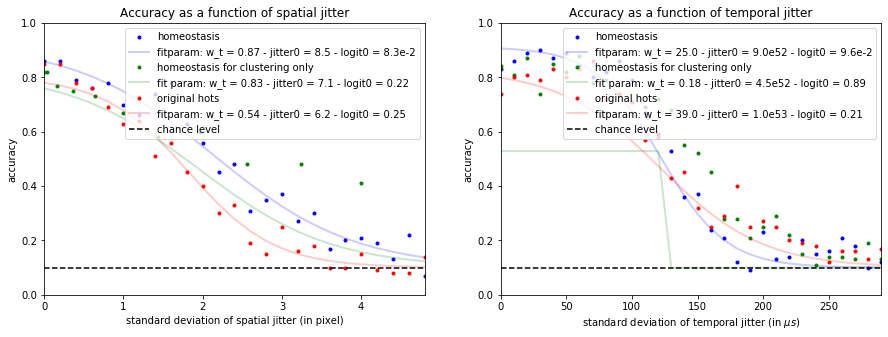

In [56]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(jit_s,score_SHH, 'b .', label='homeostasis')
axs[0].plot(jit_s, fit_SHH.detach().numpy(), "b", alpha=0.2, lw=2, label="fit"+param_SHH)
axs[0].plot(spa_jit,score_SH, 'g.', label='homeostasis for clustering only')
axs[0].plot(js_values, fit_SH.detach().numpy(), "g", alpha=0.2, lw=2, label="fit "+param_SH)
axs[0].plot(jit_s,score_S, 'r .', label='original hots')
axs[0].plot(js_values, fit_S.detach().numpy(), "r", alpha=0.2, lw=2, label="fit"+param_S)
chance = np.ones([len(jit_s)])*0.1
axs[0].plot(jit_s,chance, 'k--', label='chance level')
axs[0].axis([0,max(jit_s),0,1])
axs[0].set_xlabel('standard deviation of spatial jitter (in pixel)')
axs[0].set_ylabel('accuracy')
axs[0].set_title('Accuracy as a function of spatial jitter');
axs[0].legend()

axs[1].plot(jit_t,score_THH, 'b .', label='homeostasis')
axs[1].plot(jit_t, fit_THH.detach().numpy(), "b", alpha=0.2, lw=2, label="fit"+param_THH)
axs[1].plot(jit_t,score_TH, 'g .', label='homeostasis for clustering only')
axs[1].plot(jt_values, fit_TH.detach().numpy(), "g", alpha=0.2, lw=2, label="fit "+param_TH)
axs[1].plot(jit_t,score_T, 'r .', label='original hots')
axs[1].plot(jit_t, fit_T.detach().numpy(), "r", alpha=0.2, lw=2, label="fit"+param_T)
chance = np.ones([len(jit_t)])*0.1
axs[1].plot(jit_t,chance, 'k--', label='chance level')
axs[1].axis([0,max(jit_t),0,1])
axs[1].set_xlabel('standard deviation of temporal jitter (in $\mu s$)')
axs[1].set_ylabel('accuracy')
axs[1].set_title('Accuracy as a function of temporal jitter');
axs[1].legend()

In [40]:
printfig(fig, 'jitter.png')

In [3]:
jit_s = [0]
jit_t = [0]
dataset = 'nmnist'
records_path = '../Records'
timestr = '2021-02-13'
homeo = False
homeotest = False
sigma = None
pooling = False
homeinv = False
jitonic = [None,None] #[temporal, spatial]
jitter = False
tau = 5
nb_train = 5000
nb_test = 100
krnlinit = 'first'
nblay = 3
nbclust = 4
filt = 2

In [4]:
hotshom = network(krnlinit=krnlinit, filt=filt, tau=tau, nblay=nblay, nbclust=nbclust, homeo=homeo, sigma=sigma, homeinv=homeinv, jitter=jitter)
hotshom = hotshom.learning1by1(dataset=dataset)
trainhistomap = hotshom.running(homeotest = homeotest, nb_digit=nb_train)

../Records/nmnist/train/2021-02-13_lagorce_first_None_False_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_5000_[None, None]_histo.pkl


In [7]:
nb_test = 100
score_S, score_T = runjit(hotshom, jit_s, jit_t)
print(score_S, score_T)

../Records/nmnist/test/2021-02-13_lagorce_first_None_False_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_100_[None, 0]_histo.pkl
../Records/nmnist/test/2021-02-13_lagorce_first_None_False_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_100_[0, None]_histo.pkl
[0.76]g... - temporal jitter = 0 - score = 0.74 [0.74]
